# Tutorial 2: The Krusell-Smith model

In this notebook we solve the Krusell-Smith model from Auclert, Bardóczy, Rognlie, Straub (2021): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models" ([link to paper](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf)).

New concepts:
- **HA block**: represent heterogeneous agents at micro and macro level
- **Unwrap GE Jacobians**: insights from step-by-step, manual construction
- **Estimation**: from impulse responses to likelihood  

For more examples and information on the SSJ toolkit, please visit our [GitHub page](https://github.com/shade-econ/sequence-jacobian).

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

## 1 Model description
The model can be written in sequence space as
$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t K_{t-1}^\alpha L_t^{1-\alpha}
\\
r_t + \delta - \alpha Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha-1} 
\\
w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha}
\\
L_t - \sum_e \pi(e) e
\\
\mathcal{K}_t(\{r_s, w_s\}) - K_t
\end{pmatrix}
= \begin{pmatrix}  0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the (aggregate) endogenous variables are $\textbf{X} = (Y, K, L, r, w)$ and the only exogenous variable is $Z$. Let's normalize $\sum_e \pi(e) e = 1$ without loss of generality.

The capital function $\mathcal{K}$ follows from the household block characterized by the Bellman equation
$$
\begin{align*}
V_t(e, k_{-}) = \max_{c, k} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}_t\left[V_{t+1}(e', k)|e \right] \right\}
\\
c + k &= (1 + r_t)k_{-} + w_t e 
\\
k &\geq 0
\end{align*}
$$

We can represent this model as a Directed Acyclic Graph (DAG) in just one unknown $K$ and one target, asset market clearing. That is, we can write it as
$$
H_t(K, Z) \equiv \mathcal{K}_t\left(\left\{\alpha Z_s K_{s-1}^{\alpha-1} - \delta, (1-\alpha) Z_s K_{s-1}^{\alpha}\right\}\right) - K_t = 0
$$

## 2 Set up heterogeneous-agent block

Solving a HA problem consists of 3 distinct steps.
1. **backward iteration**: solve for individual policy functions
2. **forward iteration**: solve for distribution
3. **aggregation**: obtain macro outcomes
   
Backward iteration is model specific, and requires careful consideration. Forward iteration is fairly mechanical. It depends only on the number and type (discrete or continuous) state variables. Aggregation is completely mechanical. As such, we ask users only to provide a recipe for backward iteration. Forward iteration and aggregation is handled automatically. 

So, the main task is to write a **backward step function** that represents the Bellman equation. This has to be a single step of an iterative solution method such as value function iteration that solves for optimal policy on a grid. For the standard income fluctuation problem we're dealing with here, the endogenous gridpoint method (EGM) of [Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368) is the best practice.
- Formally, we need to write a function that maps the expected value of a "backward variable" tomorrow into the "backward variable" today, on the same grid. In the EGM, the backward variable is the partial of the value function with respect to assets, thus the backward step function is $f: \mathbb{E}\left[\partial_k V(e', k)\right|e] \to \partial_k V(e, k_{-}).$

Once we have the backward step function, we can use the decorator `@het` to turn it into an instance of HetBlock. All we have to do is specify:
- `exogenous`: name of the transition matrix for discrete exogenous state(s) (one or more, in forward order)
- `policy`: name of policy corresponding to the continuous endogenous state(s) (one or two)
- `backward`: name of backward variable(s) on which we're iterating (here the first derivative `Va` of the value function with respect to assets)
- `backward_init`: a function that initializes a guess for the backward variable 

In [2]:
def household_init(a_grid, e_grid, r, w, eis):
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va

@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, e_grid, r, w, beta, eis):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (nE, nA), expected marginal value of assets next period
    a_grid   : array (nA), asset grid
    e_grid   : array (nE), producticity grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount factor
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (nE, nA), marginal value of assets today
    a  : array (nE, nA), asset policy today
    c  : array (nE, nA), consumption policy today
    """
    uc_nextgrid = beta * Va_p
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    misc.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

Recall that every block (including HA blocks) represent a function in sequence space. HA blocks are special in that they have macro outputs (aggregates) but also micro outputs (distribution, policy functions).

In [3]:
print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'beta', 'eis', 'Pi']
Macro outputs: ['A', 'C']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c']


The inputs of the `household` block include scalars (`w`, `r`, `eis`, `beta`) and arrays (`a_grid`, `e_grid`, `Pi`). A key assumption of the SSJ method is that blocks are only connected via scalars (scalar sequences). This ensures that all blocks have compatible Jacobians that can be accumulated along the DAG. Multidimensional inputs should be thought of as **internal** to a specific HetBlock. 

This convention is facilitated by `hetinput` and `hetoutput` functions. These are regular Python functions that we can attach to a HetBlock. The purpose of hetinputs is to map scalars (from outside the block) into the multidimensional inputs that the block needs. The purpose of hetoutputs is to map multidimensional outputs of the block (e.g. `a`, `c`) into new multidimensional outputs of interest. Think of it as follows. A HetBlock is evaluated in 3 steps.
1. evaluate hetinputs; obtain multidimensional inputs
2. evaluate core block (backward iteration); obtain policy functions
3. evaluate hetoutputs; obtain other outputs of interest

A single HetBlock may have zero or multiple `hetinputs` and `hetoutputs`. Moreover, hetinputs are allowed to depend on each other in an acyclic fashion. Same for hetoutputs.  

Continuing with our example, let's attach a hetinput function that creates the grid. Notice that `household_ext` does not have multidimensional inputs anymore. It knows how to make them internally, by calling `make_grid`. 

In [4]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid


household_ext = household.add_hetinputs([make_grid])

print(household_ext)
print(f'Inputs: {household_ext.inputs}')

<HetBlock 'household' with hetinput 'make_grid'>
Inputs: ['r', 'w', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA']


- The household block above is a special case of the generic "standard incomplete markets model" that we included with the toolkit in `sequence_jacobian/examples/hetblocks/household_sim.py`. 
- The rest of the blocks that constitute the Krusell-Smith model are listed below but can also be found in `sequence_jacobian/examples/krusell_smith.py`.

In [5]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y


@simple
def mkt_clearing(K, A, Y, C, delta):
    asset_mkt = A - K
    goods_mkt = Y - C - delta * K
    return asset_mkt, goods_mkt

Let's put the model together.

In [6]:
ks = create_model([household_ext, firm, mkt_clearing], name="Krusell-Smith")
print(ks.inputs)

['beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'K', 'L', 'Z', 'alpha', 'delta']


## 3 Calibrating the steady state
Next, we calibrate the model in general equilibrium. The calibration exercise amounts to finding the right discount factor $\beta$ to hit a targeted interest rate conditional on all the other exogenous parameters. We use Brent's method, an efficient way to solve for a root on an interval, from the `scipy.optimize` package to do so.

Although additional efficiency gains would be possible here (for instance, by updating our initial guesses for policy and distribution along the way), we will not implement them, since they are not our focus here.

Our default values depart slightly from the canonical Krusell-Smith calibration, mainly by assuming a 7-state income process and a lower capital share. More risk increases the precautionary savings motive, while less capital limits the ability to self-insure. These changes lead to higher MPCs and less RA-like behavior.

In [44]:
calibration = {'eis': 1, 'delta': 0.025, 'alpha': 0.11, 'rho_e': 0.966, 'sd_e': 0.5, 'L': 1.0,
               'nE': 7, 'nA': 500, 'amin': 0, 'amax': 200}
unknowns_ss = {'beta': 0.98, 'Z': 0.85, 'K': 3.}
targets_ss = {'r': 0.01, 'Y': 1., 'asset_mkt': 0.}

ss = ks.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='hybr')

print(ss)

<SteadyStateDict: ['eis', 'delta', 'alpha', 'rho_e', 'sd_e', 'L', 'nE', 'nA', 'amin', 'amax', 'beta', 'Z', 'K', 'r', 'w', 'Y', 'A', 'C', 'asset_mkt', 'goods_mkt'], internals=['household']>


Let's inspect the steady state.
- the `solve_steady_state` method returned a `SteadyStateDict` object.
- `ss` stores variables in two levels: *top* and *internal*
- the top level contains scalars, which are accessible for all blocks of the model
- the internal level contains block-specific multidimensional variables



Let's plot the consumption policy function for all skill types  as a function of assets.

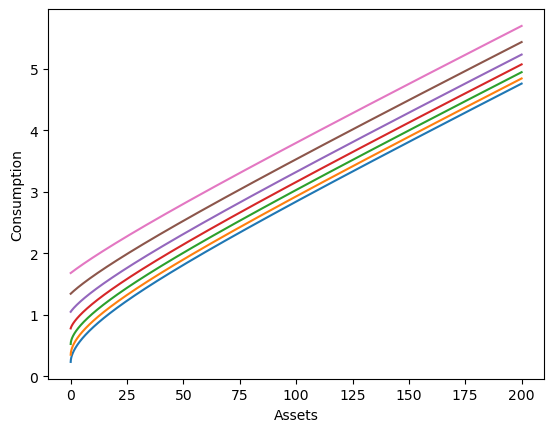

In [47]:
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'].T)
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()

### Speed of steady-state solution
Our backward and forward iterations use Numba, [a just-in-time compilation library](https://numba.pydata.org/numba-doc/dev/user/5minguide.html) that translates pure numerical Python to fast machine code. The first time functions are run, there is some compilation lag, similar to (but much less time-consuming than) compilation time in languages like C++, Fortran, and Julia.

Now that we have run everything once, we can time our steady-state calibration routine. An efficient steady state is not the focus of this notebook or our methods, but it is nice to see that performance is still quite good:

In [9]:
%time ss = ks.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

CPU times: total: 219 ms
Wall time: 1.03 s


Indeed, this simple example is so fast that increasing the number of asset gridpoints from 500 to 2000, and thus the total number of states from $7 \times 500=3500$ to $7 \times 2000 = 14000,$ increases computation time by less than a factor of four.

In [10]:
calibration_highA = {**calibration, **{"nA": 2000}}

%time _ = ks.solve_steady_state(calibration_highA, unknowns_ss, targets_ss, solver="hybr")

CPU times: total: 1.19 s
Wall time: 2.06 s


## 4 Jacobians
Jacobians are the key concept to solve and to estimate models in sequence space. Each model block has its own Jacobians, which can be combined via the chain rule into Jacobians for the complete model. A Jacobian in a $T$-dimensional (truncated) sequence space is a $T \times T$ matrix of the form

$$
\frac{d Y}{d X} = 
\begin{pmatrix}
\frac{d Y_0}{d X_0} & \frac{d Y_0}{d X_1} & \dots & \frac{d Y_0}{d X_{T-1}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d Y_{T-1}}{d X_0} & \frac{d Y_{T-1}}{d X_1} & \dots & \frac{d Y_{T-1}}{d X_{T-1}}
\end{pmatrix}
$$

evaluated at the steady state. Every column can be interpreted as the impulse response to a one-period news shock.

### 4.1 Simple blocks
To build intuition, let's start with the firm block we instantiated above. In our code, simple blocks are specified as regular Python functions with the added decorator ``@simple``. In the body of the function, we directly implement the corresponding equilibrium conditions. The decorator turns the function into an instance of ``SimpleBlock``, a class that, among other things, knows how to handle time displacements such as `K(-1)` to denote 1-period lags and `r(+1)` to denote 1-period leads. In general, one can write (-s) and (+s) to denote s-period lags and leads.

Blocks can compute their Jacobians by the `jacobian` method. This takes in the `SteadyStateDict` object returned by the `solve_steady_state` method and two optional inputs: the truncation horizon and list of variables to differentiate with respect to. It returns the Jacobians in a nested dict, where the first level is the output variable $Y$ and the second level is the input variable $X$.

In [11]:
J_firm = firm.jacobian(ss, inputs=['K', 'Z'])

print(J_firm)

<JacobianDict outputs=['r', 'w', 'Y'], inputs=['K', 'Z']>


By default, `jacobian` compoutes the Jacobian for each input-output pair. In practice, it only makes sense to do so with respect to endogenous variables and shocks, hence the `inputs` option. In this model, capital and TFP are the only inputs that will ever change.

The Jacobian is diagonal because the production function does not depend on leads or lags of productivity. Such sparsity is very common for simple blocks, and we wrote the SimpleBlock class to take full advantage of it. For example, if we leave the truncation parameter $T$ unspecified, which is recommended, `jacobian` returns a more efficient sparse representation of the Jacobian.

In [12]:
print(J_firm['Y']['Z'].matrix(3))
print('\n')
print(J_firm['Y']['Z'])

[[1.13424196 0.         0.        ]
 [0.         1.13424196 0.        ]
 [0.         0.         1.13424196]]


SimpleSparse({(0, 0): 1.134})


The output means that the only non-zero element is 1.134 along the main diagonal.

### 4.2 HA blocks
HA blocks have more complicated Jacobians, but they have a regular structure that we can exploit to calculate them very quickly. For comprehensive coverage of our **fake news algorithm**, please see the paper.

A `HetBlock` object has a `jacobian` method that is analogous to one above for `SimpleBlock` objects.

In [13]:
J_ha = household.jacobian(ss, inputs=['r', 'w'], T=5)
print(J_ha['C']['r'])

[[ 0.09578534 -0.68179015 -0.64119935 -0.60434415 -0.57057436]
 [ 0.09413756  0.13463153 -0.64841526 -0.61133486 -0.5771951 ]
 [ 0.09250592  0.12963223  0.16651934 -0.61980277 -0.58527967]
 [ 0.09087539  0.12509918  0.15952962  0.1938437  -0.59485549]
 [ 0.08926245  0.12116257  0.15312513  0.18541035  0.21770361]]


Notice that this matrix is no longer sparse. This generally the case for HA blocks. The Bellman equation implies that policies are forward-looking, and then aggregates are also backward-looking due to persistence coming via the distribution.

Our `SimpleSparse` Jacobian objects are conformable with standard `np.array` objects, so that we can easily combine the Jacobians of simple blocks and HA blocks. For example, the multiplication operator `@` maps any combination of SimpleSparse and `np.array` objects into `np.array` objects as in standard `np.array` matrix multiplication.   

In [14]:
print(J_ha['C']['r'] @ J_firm['r']['Z'])

[[ 0.00380253 -0.02706602 -0.02545463 -0.02399154 -0.02265093]
 [ 0.00373712  0.00534467 -0.02574109 -0.02426906 -0.02291376]
 [ 0.00367234  0.0051462   0.00661056 -0.02460522 -0.02323471]
 [ 0.00360761  0.00496625  0.00633308  0.0076953  -0.02361485]
 [ 0.00354358  0.00480997  0.00607883  0.00736051  0.0086425 ]]


## 5 Linearized dynamics using Jacobians
Recall that we reduced the model to a single equation $H$

$$
H_t(K, Z) \equiv \mathcal{K}_t\left(\left\{\alpha Z_s K_{s-1}^{\alpha-1} - \delta, (1-\alpha) Z_s K_{s-1}^{\alpha}\right\}\right) - K_t = 0.
$$

to be solved for $K$ given any $Z$.

This is the composition of the household capital supply function $\mathcal{K}$ with the interest rate $r(K_{t-1}, Z_t) = \alpha Z_t K_{t-1}^{\alpha-1} - \delta$ and wage $w(K_{t-1}, Z_t) = (1-\alpha) Z_t K_{t-1}^{\alpha}$ functions.

We will obtain a linear characterization of all impulse responses in two ways:
- First, by duly following the notation and algebra of section 2.2 in the paper. This hands-on approach is transparent, but error-prone in all but the simplest cases.
- Second, by leveraging the powerful convenience functions that we introduced in the RBC notebook, and further employ in the one-asset and two-asset HANK notebooks. Throughout this section, we'll use the steady state `ss` we've already solved for, and a 300-period truncation horizon.

### 5.1 Hands-on approach

##### Step 1: For each block, obtain Jacobians of outputs with respect to inputs
Here, we only have two blocks: the firm and household blocks. Getting these Jacobians is quite quick, even for the HA block.

In [15]:
# Import the JacobianDict class, since we are manually constructing Jacobians to demonstrate how the automatic construction
# works in the code
from sequence_jacobian.classes import JacobianDict

# firm Jacobian: r and w as functions of K and Z
J_firm = firm.jacobian(ss, inputs=['K', 'Z'])

# household Jacobian: curlyK (called 'a' for assets by J_ha) as function of r and w
T = 300
J_ha = household.jacobian(ss, inputs=['r', 'w'], T=T)

#### Step 2: Compose Jacobians along the DAG
Here, we manually apply the chain rule to calculate the total Jacobians of household $\mathcal{K}$ with respect to $K$ and $Z$, by composing the partial Jacobians `J_ha` (which maps $r$ and $w$ to $\mathcal{K}$) and `J_firm` (which maps $K$ and $Z$ to $r$, $w$, and $Y$).

In [16]:
J_curlyK_K = J_ha['A']['r'] @ J_firm['r']['K'] + J_ha['A']['w'] @ J_firm['w']['K']
J_curlyK_Z = J_ha['A']['r'] @ J_firm['r']['Z'] + J_ha['A']['w'] @ J_firm['w']['Z']

Now, we will combine `J_curlyK_K` and `J_curlyK_Z` with the firm Jacobians to get a single nested dict with the total Jacobians of everything with respect to $K$ and $Z$:

In [17]:
J = copy.deepcopy(J_firm)
J.update(JacobianDict({'curlyK': {'K' : J_curlyK_K, 'Z' : J_curlyK_Z}}))

#### Step 3: Invert $H_K$ to obtain impulse response $dK=-H_K^{-1}H_ZdZ$
Now we need to get the Jacobians of our equation $H(K,Z)$, which fully characterizes equilibrium, with respect to $K$ and $Z$. Once we have these, the implicit function theorem gives us the endogenous capital $dK=-H_K^{-1}H_ZdZ$ response to any exogenous shock $dZ$.

Recall that $H$ equals household capital supply $\mathcal{K}$ minus firm capital $K$, so that we can get the Jacobians almost immediately from what we have already calculated.

In [18]:
H_K = J['curlyK']['K'] - np.eye(T)
H_Z = J['curlyK']['Z']

We define $G_K \equiv -H_K^{-1}H_Z$ to be the matrix mapping from any $dZ$ to the corresponding $dK$:

In [19]:
G = {'K': -np.linalg.solve(H_K, H_Z)}

#### Step 4: Get all other impulses
In `J`, we have Jacobians of $r,w,Y$ with respect to both $Z$ and $K$. If there is a shock to $Z$, we can decompose the change in $r,w,Y$ into a "direct" effect from $dZ$ and an "indirect" effect from the induced change $dK$.

We apply the chain rule to the latter to get matrices $G_r, G_w, G_Y$ mapping any $dZ$ to the corresponding $dr,dw,dY$:

In [20]:
G['r'] = J['r']['Z'] + J['r']['K'] @ G['K']
G['w'] = J['w']['Z'] + J['w']['K'] @ G['K']
G['Y'] = J['Y']['Z'] + J['Y']['K'] @ G['K']

The `G` dict characterizes the full linearized dynamics of aggregate variables $K, r, w, Y$ in response to *any* perturbation to $Z$.

If we want the linearized dynamics of other variables, e.g. consumption, all we need is to get the Jacobian from the block in which these are calculated, and then compose it with the `G` of its inputs. It turns out that consumption was already reported in `J_ha`, so we just need to write:

In [21]:
G['C'] = J_ha['C']['r'] @ G['r'] + J_ha['C']['w'] @ G['w']

### 5.2 Convenient approach

The DAG of the model contains sufficient information to automate this process. The only other things we need to know are the steady state around which to linearize, and the truncation horizon.

In [22]:
inputs = ['Z']
unknowns = ['K']
targets = ['asset_mkt']

G2 = ks.solve_jacobian(ss, unknowns, targets, inputs, T=T)

Let's verify that the two give the same answer up to high precision (`assert` throws an error if its argument evaluates to False).

In [23]:
for o in G:
    assert np.allclose(G2[o]['Z'], G[o])

### 5.3 Results
What do the impulse responses in this model look like? The beauty of our method is that, now that we have $G$, we can compute impulse responses to any shock almost instantaneously -- it's just matrix multiplication!

Let's first consider shocks to $Z$ with different persistences, all normalized so that they have a 1% initial impact, and plot the interest rate response to each.

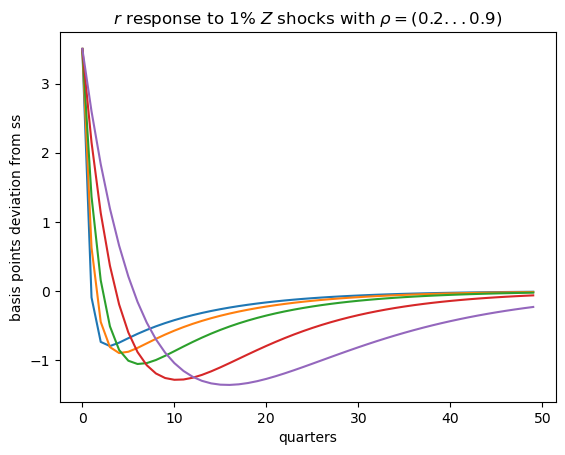

In [24]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dr = G['r'] @ dZ

plt.plot(10000*dr[:50, :])
plt.title(r'$r$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'basis points deviation from ss')
plt.xlabel(r'quarters')
plt.show()

Now let's consider 10,000 different values of rho, for which we can still calculate all $r$ impulse responses almost instantaneously.

In [25]:
rhos = np.linspace(0.1, 0.9, 10000)
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
%time dr = G['r'] @ dZ

CPU times: total: 15.6 ms
Wall time: 25.5 ms


The time taken here differs from run to run, but in the current run (like all runs on a personal laptop) it takes less than 20 milliseconds of "wall time" to compute 10,000 impulse responses means that each impulse response takes less than **2 microseconds**. "CPU time" is slightly higher because mild parallelization on two cores is used by the built-in matrix multiplication implementation. By contrast, typical impulse response calculations in heterogeneous agent models in the literature take at least a minute, so this method is more than **30 million** times faster as a way of calculating individual impulse responses.

Although this may seem like an extreme example, repeated calculations of this form are quite useful in the most computationally demanding applications, like estimation (as we will see later).

Another important feature of our sequence space methodology is that it is easy to calculate the response to shocks that are difficult to cast into simple recursive form, like news shocks.

For example, calculating the response to a news shock where $Z$ is expected to increase at a specific period in the future is trivial -- in fact, that's exactly what the columns of the $G$ matrix are. Below we plot the capital responses to news shocks of $Z$ increases at periods 5, 10, 15, 20, and 25.

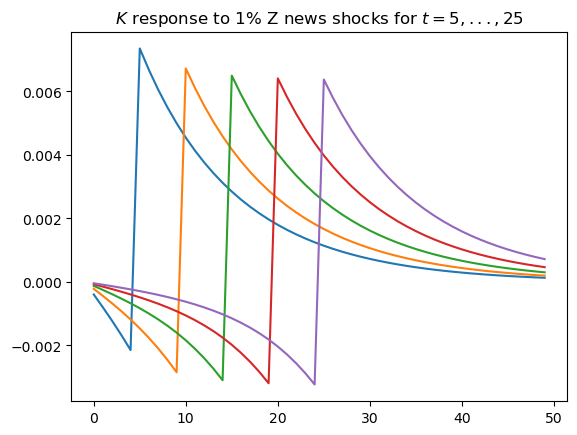

In [26]:
dZ = 0.01*(np.arange(T)[:, np.newaxis] == np.array([5, 10, 15, 20, 25]))
dK = G['K'] @ dZ

plt.plot(dK[:50])
plt.title('$K$ response to 1% Z news shocks for $t=5,...,25$')
plt.show()

## 6 Estimation

The roadmap for estimation is as follows:
 - impulse responses $\implies$ second moments
 - second moments $\implies$ log-likelihood
 
In this notebook, we will simply use simulated data to show that the log-likelihood peaks close to the true value of the estimated parameter, the standard deviation of TFP shocks. 

### 6.1 Second moments 
Thanks to certainty equivalence, linear impulse responses can be interpreted as the $MA(\infty)$ representation of the model. Then all we need is the second moments of the shocks to fully characterize the second moments of endogenous outcomes. This computation can be done in a highly efficient way, without any need for simulation.

For concreteness, let's suppose that the TFP shocks $dZ$ in the Krusell-Smith model have a persistent and transitory component.

$$
\begin{align*}
dZ_t &= dZ^1_t + d Z_t^2
\\
dZ_t^1 &= \rho d Z_{t-1}^1 + \epsilon^1_t
\\
d Z_t^2 &= \epsilon^2_t
\end{align*}
$$

where $\epsilon^1$ and $\epsilon^2$ are i.i.d. normal with mean zero and with variance $\sigma^2_1$ and $\sigma^2_2$. 

Let $m^{x, 1}$ and $m^{x,2}$ denote the (truncated) impulse responses of variable $X$ to these two structural shocks. Then we have an $MA(T-1)$ representation:

$$
X_t = \sum_{z=1}^{2} \sum_{s=0}^{T-1} m^{x,z}_s \epsilon_{t-s}^z 
$$

It follows that covariances between outcomes $Y$ and $X$ take the form

$$
\text{Cov}(Y_t, X_{t+l})= \sum_{z=1}^{2} \sigma_z^2 \sum_{s=0}^{T-1} m_s^{x,z} m_{s+l}^{y,z} \tag{Cov}
$$

#### Step 1. Stacked impulse responses

Given the $G$ matrix we calculated in section 4, this is just a matter of matrix multiplication:

In [27]:
rho = 0.9
sigma_persist = 0.1
sigma_trans = 0.2

dZ1 = rho**(np.arange(T))
dY1, dC1, dK1 = G['Y'] @ dZ1, G['C'] @ dZ1, G['K'] @ dZ1
dX1 = np.stack([dZ1, dY1, dC1, dK1], axis=1)

dZ2 = np.arange(T) == 0
dY2, dC2, dK2 = G['Y'] @ dZ2, G['C'] @ dZ2, G['K'] @ dZ2
dX2 = np.stack([dZ2, dY2, dC2, dK2], axis=1)

Let's stack all these to make a $T\times 4 \times 2$ array giving all impulse responses of the four outcomes to the two shocks:

In [28]:
dX = np.stack([dX1, dX2], axis=2)
dX.shape

(300, 4, 2)

#### Step 2. Obtain covariance at all leads and lags

The covariance formula above is implemented efficiently using the Fast Fourier Transform by the `all_covariances` function, which returns a $T\times 4\times 4$ array `Sigma`, where `Sigma[l, o1, o2]` gives the covariance for any $t$ between output `o1` at $t$ and output `o2` at $t+l$.

In [29]:
sigmas = np.array([sigma_persist, sigma_trans])
Sigma = estimation.all_covariances(dX, sigmas) # burn-in for jit
%time Sigma = estimation.all_covariances(dX, sigmas)

CPU times: total: 0 ns
Wall time: 650 µs


#### Visualizing correlations

Let's turn the covariance matrix `Sigma` into a correlation matrix, by normalizing it with the standard deviation of each series:

In [30]:
sd = np.sqrt(np.diag(Sigma[0, ...]))
correl = (Sigma/sd)/(sd[:, np.newaxis])

Finally, let's plot $\text{corr}(dZ_t,dZ_{t+l})$, $\text{corr}(dZ_t,dY_{t+l})$, $\text{corr}(dZ_t,dC_{t+l})$, and $\text{corr}(dZ_t,dK_{t+l})$, for $l$ from $-50$ through $50$: the correlations of all series, at various lags, with the driving productivity process.

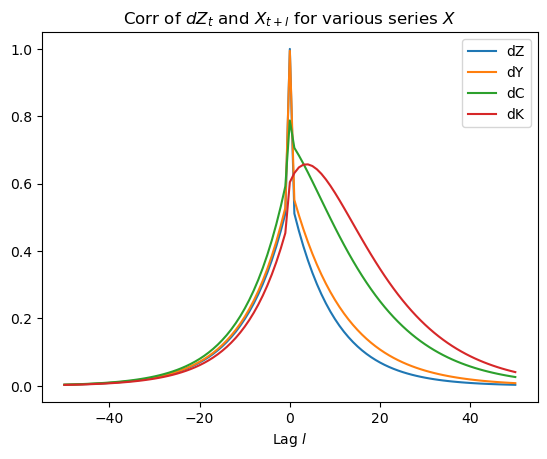

In [31]:
ls = np.arange(-50, 51)
corrs_l_positive = correl[:51, 0, :]
corrs_l_negative = correl[50:0:-1, :, 0]
corrs_combined = np.concatenate([corrs_l_negative, corrs_l_positive])

plt.plot(ls, corrs_combined[:, 0], label='dZ')
plt.plot(ls, corrs_combined[:, 1], label='dY')
plt.plot(ls, corrs_combined[:, 2], label='dC')
plt.plot(ls, corrs_combined[:, 3], label='dK')
plt.legend()
plt.title(r'Corr of $dZ_t$ and $X_{t+l}$ for various series $X$')
plt.xlabel(r'Lag $l$')
plt.show()

Here we can see many features of the solution. First, $dY$ is extremely similar to $dZ$, except that it has a greater lagged response due to capital accumulation. Both $dZ$ and $dY$ have a large peak at $l=0$ corresponding to the transitory shock. $dC$ and $dK$, on the other hand, are both much smoother and tend to lag $dZ$, especially $dK$.

### 6.2 Log-likelihood

Assuming the means of all series are zero (which is often imposed through some kind of preliminary demeaning or detrending procedure on the data), and that the shocks are multivariate normal, all we really need to evaluate the log-likelihood are the second moments and the data.

Specifically, if our data observations are stacked in a vector $\mathbf{y}$ and the covariances at all lags are stacked in a matrix $\mathbf{V}$, then the log-likelihood is (up to a constant):

$$
\mathcal{L} = -\frac{1}{2}\log(\det(\mathbf{V})) - \frac{1}{2}\mathbf{y}'\mathbf{V}^{-1}\mathbf{y} \tag{log-likelihood}
$$ 

Our code proceeds directly from the covariances `Sigma` at all lags returned by `all_covariances` in the last section, and the matrix of data series, implementing (log-likelihood) under the hood to calculate the log-likelihood.

In [32]:
# random 100 observations
Y = np.random.randn(100, 4)

# 0.05 measurement error in each variable
sigma_measurement = np.full(4, 0.05)

# calculate log-likelihood
estimation.log_likelihood(Y, Sigma, sigma_measurement)

%time estimation.log_likelihood(Y, Sigma, sigma_measurement)

CPU times: total: 0 ns
Wall time: 0 ns


-53376.316739883536

### 6.3 Putting it together: calculating the likelihood in an example
Continue to consider the shock process from section 5.1, where $dZ$ had one persistent component and one transitory component. Imagine that we do not know the persistence parameter $\rho$ of the persistent component, nor do we know the relative variances of these two shocks or the variances of the measurement errors. Given some observed data $\mathbf{w}$ with 100 observations of $dZ, dY, dC, dY$, what does the log-likelihood as a function of these parameters look like, and how do we compute it?

We write the following function.

In [33]:
def log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigma_measurement, Y):
    # impulse response to persistent shock
    dZ1 = rho**(np.arange(T))
    dY1, dC1, dK1 = G['Y'] @ dZ1, G['C'] @ dZ1, G['K'] @ dZ1
    dX1 = np.stack([dZ1, dY1, dC1, dK1], axis=1)
    
    # since transitory shock does not depend on any unknown parameters,
    # except scale sigma_trans, we just reuse the dX2 already calculated earlier!
    
    # stack impulse responses together to make MA(T-1) representation 'M'
    M = np.stack([dX1, dX2], axis=2)
    
    # calculate all covariances
    Sigma = estimation.all_covariances(M, np.array([sigma_persist, sigma_trans]))
    
    # calculate log=likelihood from this
    return estimation.log_likelihood(Y, Sigma, sigma_measurement)

**Simulate sample data.** Now let's simulate more realistic series $w=\{dZ, dY, dC, dK\}$, assuming the same parameters as above, to see what evaluating the log-likelihood is like.

In [34]:
# stack covariances into matrix using helper function, then do a draw using NumPy routine
V = estimation.build_full_covariance_matrix(Sigma, sigma_measurement, 100)
Y = np.random.multivariate_normal(np.zeros(400), V).reshape((100, 4))

Now let's plot the log-likelihood of $w$ as a function of the standard deviation of the persistent component (the true value of which is 0.1), given correct values for all other parameters. Note that evaluating the log-likelihood 100 times takes well below one second.

In [35]:
sigma_persist_values = np.linspace(0.05, 0.2, 100)
%time lls = np.array([log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigma_measurement, Y) for sigma_persist in sigma_persist_values])

CPU times: total: 203 ms
Wall time: 333 ms


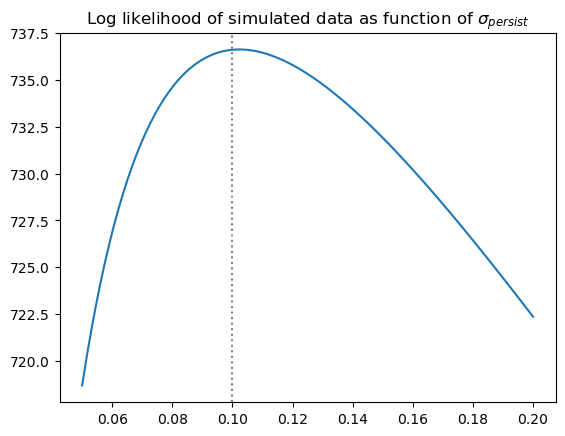

In [36]:
plt.plot(sigma_persist_values, lls)
plt.axvline(0.1, linestyle=':', color='gray')
plt.title(r'Log likelihood of simulated data as function of $\sigma_{persist}$')
plt.show()

Reassuringly, the mode is near (although not exactly at, since we're simulating a finite sample with only 100 periods) the value of $\sigma_{persist}=0.1$ with which the data was simulated!

## 8 Nonlinear perfect foresight dynamics
Linearized impulse responses are invariant to the sign and size of aggregate shocks by construction. Although this is not a problem for many applications, it is clearly a limitation. Here, we demonstrate that the Jacobian is also extremely useful in solving for nonlinear dynamics.

Consider the case of an economy that starts at the steady state, and receives an unexpected shock at date 0. This is often called an "MIT shock". 

For a given shock $Z$, the solution is still characterized by the $K$ that solves $H(K,Z)=0$. Our algorithm to find this $K$, a simple variant of Newton's method, iterates on a sequence of guesses $K^j$ for the path of capital as follows:
1. starting with $j=0$, guess a path $K^0$
2. calculate $H(K^j, Z)$
3. update the guess according to $$K^{j+1} = K^j - H_K(K_{ss}, Z_{ss})^{-1} H(K^j, Z)$$
and return to step 2 for $j+1$

The only difference between this and the standard Newton's method is that we use the Jacobian $H_K$ around the steady state (which we have already calculated), rather than the Jacobian around the current guess (which is somewhat more difficult to calculate). Still, this tends to achieve extremely fast convergence.

Although iterative methods to solve for equilibrium in response to MIT shocks are quite common in the heterogeneous-agent literature, these methods generally use ad-hoc rules for updating the guess, which can be fragile and slow. In applications with no or limited heterogeneity (such as spender-saver models) where it is possible to calculate Jacobians easily, Newton's method has been used to provide faster and more robust convergence -- see, for instance, [Juillard (1996)](http://www.cepremap.fr/depot/couv_orange/co9602.pdf).

But until now, this has not been applied to heterogeneous-agent models, since the Jacobian has been too difficult to calculate. The only partial applications to date, to our knowledge, are in [Auclert and Rognlie (2018)](http://web.stanford.edu/~aauclert/computational_appendix_inequad.pdf), which uses an auxiliary model to compute an approximate Jacobian, and in [Straub (2018)](https://scholar.harvard.edu/files/straub/files/jmp_straub_jan_2.pdf), which uses interpolation to compute an approximate Jacobian. In this paper, however, we have provided a highly efficient method to compute the *exact* Jacobian around the steady state for any heterogeneous-agent model, and can thus readily apply Newton's method.

### 8.1 Implementation

Our quasi-Newton method can be implemented in two steps. First, build the nonlinear function $H(U, Z).$ Second, guess $U$ for a given $Z$ and iterate until convergence. We automatized both of these, so all we need to do is call the `solve_impulse_nonlinear` method for the `ks` object. We will also solve for the linearized dynamics using the `solve_impulse_linear` method for comparison. 

Note that both the shock and the results (in an `ImpulseDict` object) are expressed in deviations from ss.

In [37]:
Z_shock_path = {"Z": 0.01*0.8**np.arange(T)}

td_nonlin = ks.solve_impulse_nonlinear(ss, unknowns, targets, Z_shock_path)
td_lin = ks.solve_impulse_linear(ss, unknowns, targets, Z_shock_path)

print(td_nonlin)

Solving Krusell-Smith for ['K'] to hit ['asset_mkt']
On iteration 0
   max error for asset_mkt is 3.37E-02
On iteration 1
   max error for asset_mkt is 5.73E-05
On iteration 2
   max error for asset_mkt is 1.26E-07
On iteration 3
   max error for asset_mkt is 1.75E-10
<ImpulseDict: ['Z', 'K', 'A', 'C', 'r', 'w', 'Y', 'asset_mkt', 'goods_mkt'], internals=['household']>


We see that this is quite quick, taking only 3 iterations after the initial guess to achieve high accuracy -- far fewer than typical ad-hoc updating rules, which can take hundreds or even thousands of iterations.

Now let's compare to the results we'd get for the linearized impulse response, and plot the paths for the real interest rate $r$.

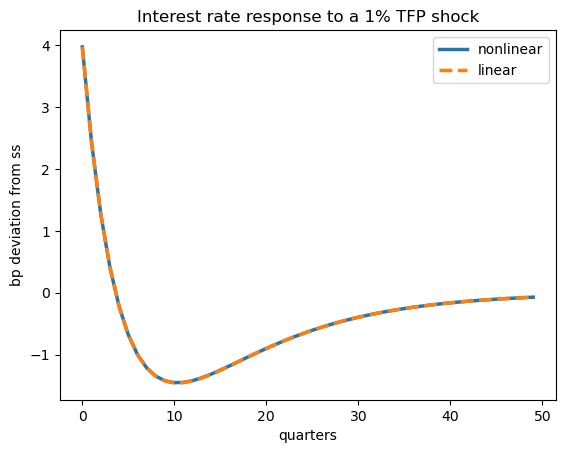

In [38]:
dr_nonlin = 10000 * td_nonlin['r']
dr_lin = 10000 * td_lin['r']

plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'Interest rate response to a 1% TFP shock')
plt.ylabel(r'bp deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

There is no visible difference -- the first-order approximation is almost perfect here.

If we increase the size of the productivity shock on impact to 10% (enormous!), we can begin to see small nonlinearities kick in, and the solution requires five iterations rather than three:

Solving Krusell-Smith for ['K'] to hit ['asset_mkt']
On iteration 0
   max error for asset_mkt is 3.47E-01
On iteration 1
   max error for asset_mkt is 5.22E-03
On iteration 2
   max error for asset_mkt is 1.16E-04
On iteration 3
   max error for asset_mkt is 1.69E-06
On iteration 4
   max error for asset_mkt is 1.13E-08
On iteration 5
   max error for asset_mkt is 2.95E-10


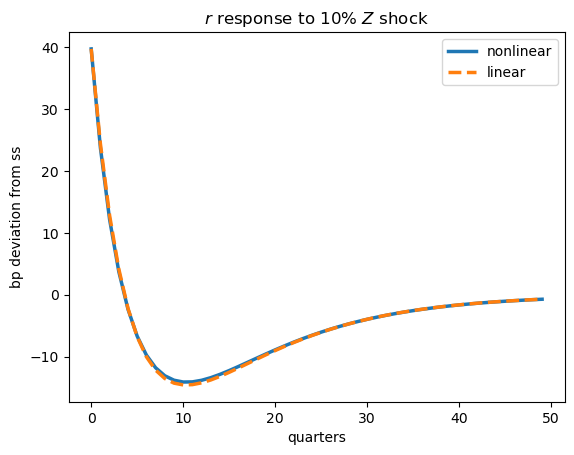

In [39]:
big_Z_shock_path = {"Z": 0.1*0.8**np.arange(T)}

td_nonlin = ks.solve_impulse_nonlinear(ss, unknowns, targets, big_Z_shock_path)
td_lin = ks.solve_impulse_linear(ss, unknowns, targets, big_Z_shock_path)

# extract interest rate response, scale to basis points
dr_nonlin = 10000 * td_nonlin['r']
dr_lin = 10000 * td_lin['r']

plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'$r$ response to 10% $Z$ shock')
plt.ylabel(r'bp deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()